# Set Up and libraries

In [1]:
%%capture
# Descargamos el dataframe desde data_download.ipynb con las imagenes asociadas.
!wget https://www.dropbox.com/scl/fi/cebo44ixv3003vba68pio/reviews_vermont.csv?rlkey=l272gentnbu9euyzixn32kig2&st=x461x04h&dl=0
!wget https://www.dropbox.com/scl/fi/h5rjz0bmrqzfgpbr1d56t/new_images.zip?rlkey=00x7kxvw7qquloqvhxdai70dn&st=rv1qn7f3&dl=0

!mv new_images.zip?rlkey=00x7kxvw7qquloqvhxdai70dn images.zip
!mv reviews_vermont.csv?rlkey=l272gentnbu9euyzixn32kig2 reviews_vermont.csv
!unzip -qq images.zip

In [2]:
%%capture
# Descargamos el dataset asociado de Vermont (tiene toda la informacion).
!wget https://www.dropbox.com/scl/fi/uznju0fkgnwz1yi4cmgol/review-Vermont.json.gz?rlkey=4l3mithogu5c08x5lxe6pbb6t&st=wcprbsjo&dl=0
!wget https://www.dropbox.com/scl/fi/16vy3q077mz01n4r2nml1/meta-Vermont.json.gz?rlkey=zu5joaocmaqdg0p17oj14z5lz&st=kih98lc6&dl=0

!mv review-Vermont.json.gz?rlkey=4l3mithogu5c08x5lxe6pbb6t review-Vermont.json.gz
!mv meta-Vermont.json.gz?rlkey=zu5joaocmaqdg0p17oj14z5lz meta-Vermont.json.gz

In [3]:
%%capture
!pip install pyreclab
!pip install cornac

In [4]:
import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time
# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR
import torch



In [5]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

# Data Preprocessing

In [6]:
metadata = list(parse("meta-Vermont.json.gz"))
reviews = list(parse("review-Vermont.json.gz"))

In [8]:
def image_exists(img_url):
    return img_url in image_files
df = pd.read_csv('reviews_vermont.csv')
print(df.shape) # [TODO: revisar download_data.ipynb]
image_files = os.listdir('new_images')
df = df[df['img_url'].apply(image_exists)]
print(df.shape)

(1169, 5)
(1169, 5)


In [9]:
df.head()

,user_id,gmap_id,rating,text,img_url
0,103949805645203359878,0x4cca9d0401cd8345:0xfd0f1a365e865e14,5,Consistently hits the spot for a straightforwa...,0x4cca9d0401cd8345:0xfd0f1a365e865e14.png
1,101675045093430739016,0x89e0e7a4069e3d61:0x1af55786531d8d9d,5,From start to finish a perfect experience. Pa...,0x89e0e7a4069e3d61:0x1af55786531d8d9d.png
2,115300326029580828414,0x89e051f190635a89:0x56ebe0d777708856,5,Cozy cafe with the most delicious sandwiches. ...,0x89e051f190635a89:0x56ebe0d777708856.png
3,118345070711245440943,0x89e11b846c8dda3f:0x6ba26f2491aacf4b,5,Great Italian food. We both had veal and sauce...,0x89e11b846c8dda3f:0x6ba26f2491aacf4b.png
4,105352358565599354309,0x89e0e67384a93239:0x99b3594193801be3,5,We visited during week two of when they opened...,0x89e0e67384a93239:0x99b3594193801be3.png


In [10]:
df_uir = df[['user_id', 'gmap_id', 'rating']]

In [11]:
SIZE = 0.7
n_rows = int(df_uir.shape[0] * SIZE)

In [12]:
X_train, X_test = train_test_split(df_uir, test_size=0.2, random_state=42)

In [13]:
print(X_test.shape[0] + X_train.shape[0], df_uir.shape[0])

1169 1169


In [14]:
X_test.shape, X_train.shape

((234, 3), (935, 3))

In [15]:
X_train.to_csv('reviews_train.csv', index=False)
X_test.to_csv('reviews_test.csv', index=False)

# Models

## Most popular

In [16]:
model_mp = pyreclab.MostPopular(
    dataset= 'reviews_train.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2
)

In [17]:
model_mp.train(progress=True)

In [18]:
reclist, map, ndcg = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2,
    topn = 10,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

In [19]:
def find_user(user_id):
    for review in reviews:
        review_uid = review['user_id']
        if review_uid != user_id: continue
        user_name = review['name']
        return user_name


In [20]:
users = list(reclist.keys())
user_1 = random.choice(users)
user_name = find_user(user_1)
user_reclist = reclist[user_1]
print(user_name)

Alana Nedelko


### Ejemplo

In [21]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'url' : [],
        'categories': []

    }
    for d in metadata:
        if d['gmap_id'] not in reclist: continue
        categories = ", ".join(d['category'])

        rec_business_cols['name'].append(d['name'])
        rec_business_cols['description'].append(d['description'])
        rec_business_cols['url'].append(d['url'])

        rec_business_cols['categories'].append(categories)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df

In [22]:
show_recommendations(user_1, user_reclist)

,name,description,url,categories
0,Cold Cow Creamery,None,https://www.google.com/maps/place//data=!4m2!3...,"Ice cream shop, Fast food restaurant, Hamburge..."
1,Ledgewood Yurt,None,https://www.google.com/maps/place//data=!4m2!3...,American restaurant
2,Roasters Cafe & Deli,None,https://www.google.com/maps/place//data=!4m2!3...,"Deli, Takeout Restaurant, Restaurant, Sandwich..."
3,Subway,Casual counter-serve chain for build-your-own ...,https://www.google.com/maps/place//data=!4m2!3...,"Sandwich shop, Caterer, Fast food restaurant, ..."
4,Zen Gardens,Standard spot offering traditional Chinese far...,https://www.google.com/maps/place//data=!4m2!3...,"Chinese restaurant, Restaurant"
5,Exit Ate Restaurant,None,https://www.google.com/maps/place//data=!4m2!3...,American restaurant
6,Green Goddess Café,"A casual global menu of breakfast fare, sandwi...",https://www.google.com/maps/place//data=!4m2!3...,"Sandwich shop, Bakery, Breakfast restaurant, B..."
7,Public House Diner,None,https://www.google.com/maps/place//data=!4m2!3...,"Breakfast restaurant, Brunch restaurant, Coffe..."
8,Bar802,Relaxed hangout with a cabin-style interior se...,https://www.google.com/maps/place//data=!4m2!3...,"Bar, Restaurant"
9,Panera Bread,Counter-serve bakery/cafe chain serving sandwi...,https://www.google.com/maps/place//data=!4m2!3...,"Cafe, Bakery, Breakfast restaurant, Caterer, C..."


### Metricas

In [23]:
def metrics(user_id, reclist):
    parameters = (user_id, reclist, 10, 3.5, False)
    auc = round(model_mp.AUC(*parameters), 6)
    ndcg = model_mp.nDCG(*parameters)
    print(f'MAP@10: {map}')
    print(f'DCG@10: {ndcg}')


In [24]:
metrics(user_1, user_reclist)

MAP@10: 0.0
DCG@10: 0.0


## Random

In [25]:
def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def evaluate_model(random_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        reclist = random_reclist[u]
        rel_vector = [np.isin(user_items_test[u], reclist, assume_unique=True).astype(int)]
        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_items_test[u]))

    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_ap, mean_ndcg


In [26]:
user_items_train = {}
itemset = set()

for row in X_train.itertuples():
    if row[1] not in user_items_train:
        user_items_train[row[1]] = []

    user_items_train[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))


user_items_test = {}

for row in X_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [27]:
random_recommendations = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['gmap_id'].to_list(), k=10))
    random_recommendations[user_id] = reclist

### Ejemplo

In [28]:
user_2 = random.choice(list(user_items_test.keys()))

In [29]:
show_recommendations(user_2, random_recommendations[user_2])

,name,description,url,categories
0,McDonald's,"Classic, long-running fast-food chain known fo...",https://www.google.com/maps/place//data=!4m2!3...,"Fast food restaurant, Breakfast restaurant, Co..."
1,The Copper Fox,None,https://www.google.com/maps/place//data=!4m2!3...,"Restaurant, Takeout Restaurant"
2,Jensen's,None,https://www.google.com/maps/place//data=!4m2!3...,"American restaurant, Breakfast restaurant, Lun..."
3,Sugar House,None,https://www.google.com/maps/place//data=!4m2!3...,Restaurant
4,Smokin' Bowls,None,https://www.google.com/maps/place//data=!4m2!3...,Restaurant
5,House of Tang,None,https://www.google.com/maps/place//data=!4m2!3...,Chinese restaurant
6,Hostel Tevere,"Simple, mixed-gender dorms in a casual hostel ...",https://www.google.com/maps/place//data=!4m2!3...,"Restaurant, Bar, Hostel"
7,August First,"European-style breads & pastries, plus salads ...",https://www.google.com/maps/place//data=!4m2!3...,"American restaurant, Bakery, Breakfast restaur..."
8,The New American Grill,None,https://www.google.com/maps/place//data=!4m2!3...,Family restaurant
9,Cilantro,None,https://www.google.com/maps/place//data=!4m2!3...,"Mexican restaurant, Fast food restaurant"


### Metricas

In [30]:
mean_ap, mean_ndcg = evaluate_model(random_recommendations, n=10)
print("nDCG@10", mean_ndcg)
print("MAP@10", mean_ap)


nDCG@10 0.0
MAP@10 0.0


## Multimodal Recsys (v.1.0)

In [31]:
# * Codigo obtenido del practico 4 *

modelo_escogido = 'vgg16' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
imgs_model_width, imgs_model_height = 224, 224

In [33]:
df_sample = df

In [34]:
print(df_sample.value_counts('rating'))
print(df_sample.shape)

rating
5    778
4    227
3     76
1     59
2     29
Name: count, dtype: int64
(1169, 5)


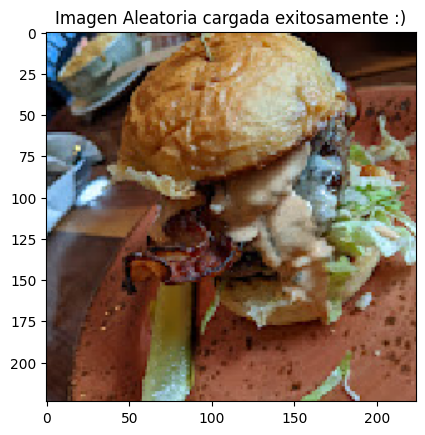

In [36]:
FOLDER = 'new_images'
files = df_sample['img_url'].tolist()
idx =  random.randint(0, len(files))
original = load_img(f'{FOLDER}/{files[idx]}', target_size=(imgs_model_width, imgs_model_height))
plt.title("Imagen Aleatoria cargada exitosamente :)")
plt.imshow(original)
plt.show()


In [38]:
# En una lista iremos guardando cada imagen preprocesada
all_images = []
for f in files:
    prefix = 'new_images'
    filename = f'{prefix}/{f}'
    original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    all_images.append(image_batch)

images = np.vstack(all_images)

processed_imgs = preprocess_input(images.copy()) # preprocesamos todas las imagenes
imgs_features = feat_extractor.predict(processed_imgs)
print("features extraidos exitosamente! :)")
print(imgs_features.shape)


37/37 ━━━━━━━━━━━━━━━━━━━━ 660s 18s/step
features extraidos exitosamente! :)
(1169, 4096)


In [39]:
with open('imgs_features.npy', 'wb') as file: # guardamos los embeddings
    np.save(file, imgs_features)

In [ ]:
# Descomentar para cargar el archivo de los embeddings
#with open('imgs_features.npy', 'rb') as file:
#    np.load(file)

In [40]:
userset = set(df_sample['user_id'].tolist())
itemset = set(df_sample['gmap_id'].tolist())
user_to_idx = {user: idx for idx, user in enumerate(userset)}
item_to_idx = {item: idx for idx, item in enumerate(itemset)}

idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}


In [55]:
VOCAB_SIZE = 5000
item_text_modality = TextModality(
    corpus=df_sample['text'].tolist(),
    id_map=item_to_idx,
    max_vocab=VOCAB_SIZE,
    tokenizer=BaseTokenizer()
)

In [56]:
item_image_modality = ImageModality(
    features=imgs_features,
    ids=item_to_idx
    )

In [57]:
uir_list = df_sample[['user_id', 'gmap_id', 'rating']].values.tolist()

In [58]:
SEED = 42
VERBOSE = True
USE_GPU = torch.cuda.is_available()


In [63]:
ratio_split = RatioSplit(
    data=uir_list,
    test_size=0.3,
    rating_threshold=3.5,
    item_text=item_text_modality, # agregamos la modalidad de texto
    item_image=item_image_modality, # agregamos la modalidad de imagen
    exclude_unknowns=False,
    seed=SEED,
    verbose=VERBOSE,
)


rating_threshold = 3.5
exclude_unknowns = False
---
Training data:
Number of users = 713
Number of items = 818
Number of ratings = 818
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 984
Number of items = 1169
Number of ratings = 351
Number of unknown users = 271
Number of unknown items = 351
---
Total users = 984
Total items = 1169


In [64]:
# baseline MostPopular
most_pop = cornac.models.MostPop()

# modelo CDL (Collaborative Deep Learning)
cdl = cornac.models.CDL(
    k=50, # dimension factor latente
    autoencoder_structure=[200],  # N° de neuronas de la capa code/decoder para SDAE
    vocab_size=VOCAB_SIZE, # cantidad maxima de vocabulario
    act_fn='tanh',
    max_iter=50,
    seed=SEED,
    verbose=VERBOSE
)
# modelo VBPR (Visual Bayesian Personalized Ranking)
vbpr = cornac.models.VBPR(
    k=10, # dimension de gamma en el espacio latente
    k2=40,  # dimension de theta en el espacio latente
    n_epochs=50,
    use_gpu=USE_GPU,
    seed=SEED,
    verbose=VERBOSE
)

## Metricas

In [65]:
def get_metrics(n):
    # numero de n elementos en la lista de recomendacion
    RMSE_n = cornac.metrics.RMSE()
    AUC_n = cornac.metrics.AUC()
    MAP_n = cornac.metrics.MAP()
    MRR_n = cornac.metrics.MRR()

    Recall_n = cornac.metrics.Recall(k=n)
    Precision_n = cornac.metrics.Precision(k=n)
    F1_n = cornac.metrics.FMeasure(k=n)
    nDCG_n = cornac.metrics.NDCG(k=n)
    return [RMSE_n, AUC_n, MAP_n, Recall_n, Precision_n, F1_n, nDCG_n, MRR_n]


In [66]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[most_pop, cdl, vbpr],
                             metrics=get_metrics(n=10))
text_exp.run()


[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/351 [00:00<?, ?it/s]

Ranking:   0%|          | 0/331 [00:00<?, ?it/s]


[CDL] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/351 [00:00<?, ?it/s]

Ranking:   0%|          | 0/331 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/9 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/351 [00:00<?, ?it/s]

Ranking:   0%|          | 0/331 [00:00<?, ?it/s]


TEST:
...
        |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MostPop | 0.8329 | 0.0000 | 0.0007 | 0.0009 | 0.0046 |  0.0036 |       0.0004 |    0.0036 |    0.0011 |   0.5421
CDL     | 0.8329 | 0.0000 | 0.0007 | 0.0009 | 0.0047 |  0.0036 |       0.0004 |    0.0036 |   28.1686 |   0.6236
VBPR    | 2.3259 | 0.5249 | 0.0007 | 0.0049 | 0.0049 |  0.0014 |       0.0004 |    0.0036 |    9.7183 |   2.4580



# Fuentes:
> [1] Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).

> [2] He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.

Links:

> (1) https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/02_multimodality.ipynb

> (2) https://github.com/PreferredAI/tutorials/tree/master

In [67]:
def get_reclist(id_user, model, n):
    """ funcion que retorna la lista de recomendaciones para un usuario.
    Valido solo para modelos de cornac. """
    scores_for_user = model.score(id_user)
    scores_for_user = [
        (idx_to_item[idx], score) for idx, score in enumerate(scores_for_user)
    ]
    scores_for_user.sort(key=lambda x: x[1], reverse=True)
    return [i[0] for i in scores_for_user[:n]]

In [68]:
user_3 = random.choice(list(idx_to_user.keys()))
print("ID Usuario: ", idx_to_user[user_3])

ID Usuario:  115175780392880441681


In [69]:
user3_reclist = get_reclist(user_3, vbpr, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

,name,description,url,categories
0,Chop House,None,https://www.google.com/maps/place//data=!4m2!3...,"Bar & grill, Restaurant"
1,India House Restaurant,Unassuming North Indian option providing tradi...,https://www.google.com/maps/place//data=!4m2!3...,Indian restaurant
2,Heritage Deli & Bakery,None,https://www.google.com/maps/place//data=!4m2!3...,"Sandwich shop, Bakery, Breakfast restaurant, C..."
3,Chipotle Mexican Grill,None,https://www.google.com/maps/place//data=!4m2!3...,"Mexican restaurant, Caterer, Fast food restaurant"
4,Apple Core,None,https://www.google.com/maps/place//data=!4m2!3...,American restaurant
5,Shinjuku Station,None,https://www.google.com/maps/place//data=!4m2!3...,Sushi restaurant
6,Maple Sugar & Vermont Spice,All-day breakfasts & homey lunch classics prep...,https://www.google.com/maps/place//data=!4m2!3...,"Breakfast restaurant, Restaurant"
7,Halvorson's,Family-run joint furnishing local beers & hear...,https://www.google.com/maps/place//data=!4m2!3...,"Bar & grill, Restaurant"
8,Curtis' All American Bar-Be-Que,Open-air roadside stop doling out pit-smoked B...,https://www.google.com/maps/place//data=!4m2!3...,"Barbecue restaurant, Restaurant"
9,242 Texas BBQ,None,https://www.google.com/maps/place//data=!4m2!3...,Barbecue restaurant


In [70]:
user3_reclist = get_reclist(user_3, most_pop, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

,name,description,url,categories
0,Wild Roots Restaurant,None,https://www.google.com/maps/place//data=!4m2!3...,Restaurant
1,Northeast Kingdom Country Store,None,https://www.google.com/maps/place//data=!4m2!3...,"Pizza restaurant, Antique store, Bakery, Beer ..."
2,Eaton's Sugar House,None,https://www.google.com/maps/place//data=!4m2!3...,"Breakfast restaurant, Gift shop"
3,Leonardo's Pizza,Local pizzeria chain offering classic & gourme...,https://www.google.com/maps/place//data=!4m2!3...,"Pizza restaurant, Delivery Restaurant"
4,Mildred's Grill,None,https://www.google.com/maps/place//data=!4m2!3...,"New American restaurant, American restaurant, ..."
5,Sakura Sushi & Kitchen,Unassuming counter-service place in a strip ma...,https://www.google.com/maps/place//data=!4m2!3...,"Japanese restaurant, Asian restaurant, Sushi r..."
6,Moe's Southwest Grill,Counter-serve chain dishing up Southwestern st...,https://www.google.com/maps/place//data=!4m2!3...,"Mexican restaurant, Burrito restaurant, Restau..."
7,Three Brothers Pizza and Grill,Quick-serve pizza & sandwich counter in an ex-...,https://www.google.com/maps/place//data=!4m2!3...,"Pizza restaurant, Caterer, Italian restaurant,..."
8,Papa Pete's Home of the Giant Pancakes,"Jumbo pancakes, omelets & burgers are provided...",https://www.google.com/maps/place//data=!4m2!3...,"Diner, Breakfast restaurant, Hamburger restaurant"
9,Pizza Hut,Family-friendly chain known for its made-to-or...,https://www.google.com/maps/place//data=!4m2!3...,"Pizza delivery, Chicken wings restaurant, Take..."


In [71]:
user3_reclist = get_reclist(user_3, cdl, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

,name,description,url,categories
0,Subway,Casual counter-serve chain for build-your-own ...,https://www.google.com/maps/place//data=!4m2!3...,"Sandwich shop, Caterer, Fast food restaurant, ..."
1,O'Dwyer's Public House,None,https://www.google.com/maps/place//data=!4m2!3...,"Restaurant, Bar"
2,Starbucks,Seattle-based coffeehouse chain known for its ...,https://www.google.com/maps/place//data=!4m2!3...,"Coffee shop, Breakfast restaurant, Cafe, Coffe..."
3,The Garden Market,None,https://www.google.com/maps/place//data=!4m2!3...,Restaurant
4,Chelsea Station,None,https://www.google.com/maps/place//data=!4m2!3...,American restaurant
5,Cantina Di Gerardo,None,https://www.google.com/maps/place//data=!4m2!3...,"Italian restaurant, Lunch restaurant"
6,Wendy's,Fast-food burger chain serving sides such as c...,https://www.google.com/maps/place//data=!4m2!3...,"Fast food restaurant, Hamburger restaurant, Re..."
7,Olive Garden Italian Restaurant,"Lively, family-friendly chain featuring Italia...",https://www.google.com/maps/place//data=!4m2!3...,"Italian restaurant, Caterer, Family restaurant..."
8,Curtis' All American Bar-Be-Que,Open-air roadside stop doling out pit-smoked B...,https://www.google.com/maps/place//data=!4m2!3...,"Barbecue restaurant, Restaurant"
9,Koto Japanese Restaurant,Bustling option for flaming hibachi-grill thea...,https://www.google.com/maps/place//data=!4m2!3...,"Japanese restaurant, Asian restaurant, Bar, Re..."
